# <hr style="clear: both" />

# Running Spark in YARN-client mode

This notebook demonstrates how to set up a SparkContext that uses SURFsara's Hadoop cluster: [YARN resourcemanager](http://head05.hathi.surfsara.nl:8088/cluster) (note you will need to be authenticated via kerberos on your machine to visit the resourcemanager link) for executors.

First initialize kerberos via a Jupyter terminal. 
In the terminal execute: <BR>
<i>kinit -k -t data/robertop.keytab robertop@CUA.SURFSARA.NL</i><BR>
Print your credentials:


In [1]:
! klist

Ticket cache: FILE:/tmp/krb5cc_1000
Default principal: robertop@CUA.SURFSARA.NL

Valid starting       Expires              Service principal
05/21/2016 07:40:06  05/22/2016 07:40:06  krbtgt/CUA.SURFSARA.NL@CUA.SURFSARA.NL
	renew until 05/21/2016 07:40:06


In [2]:
! hdfs dfs -ls 
execfile('../spark-scripts/bullet.py')

Found 5 items
drwx------   - robertop hdfs          0 2016-05-20 06:00 .Trash
drwxr-xr-x   - robertop hdfs          0 2016-05-21 09:13 .sparkStaging
drwx------   - robertop hdfs          0 2016-04-06 15:54 .staging
drwxr-xr-x   - robertop hdfs          0 2016-05-19 19:23 mattia
drwxr-xr-x   - robertop hdfs          0 2016-04-13 10:00 recsys2016Competition


Verify that we can browse HDFS:

Next initialize Spark. Note that the code below starts a job on the Hadoop cluster that will remain running while the notebook is active. Please close and halt the notebook when you are done. Starting the SparkContext can take a little longer. You can check the YARN resourcemanager to see the current status/usage of the cluster.

In [3]:
import os
os.environ['PYSPARK_PYTHON'] = '/usr/local/bin/python2.7'

HDFS_PATH = "hdfs://hathi-surfsara"

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sconf = SparkConf(False)

sconf.setAppName("sim-sessions")

# Master is now yarn-client. The YARN and hadoop config is read from the environment
sconf.setMaster("yarn-client")

# You can control many Spark settings via the SparkConf. This determines the amount of executors on the cluster:
sconf.set("spark.executor.instances", "200")
sconf.set("spark.executor.memory", "10g")

# UFW (firewall) is active on the VM. We explicitly opened these ports and Spark should not bind to random ports:
sconf.set("spark.driver.port", 51800)
sconf.set("spark.fileserver.port", 51801)
sconf.set("spark.broadcast.port", 51802)
sconf.set("spark.replClassServer.port", 51803)
sconf.set("spark.blockManager.port", 51804)
sconf.set("spark.authenticate", True)
sconf.set("spark.yarn.keytab", "/home/jovyan/work/data/robertop.keytab")
sconf.set("spark.yarn.access.namenodes", HDFS_PATH + ":8020")

try:
    sc = SparkContext(conf=sconf)
    sqlCtx = SQLContext(sc) 
    sendNotificationToMattia("Spark Context", "Ready!")
except Exception, err:
    sendNotificationToMattia("Fuck you!", str(err)) 
    print str(err)

# <hr style="clear: both" />

# Now you can run your code

Pick a clustering algorithm (name of the file that provides a classify(x,y [,threshold]) function)

In [4]:
import json
execfile('../spark-scripts/utilsCluster.py')
execfile('../spark-scripts/conventions.py')
execfile('../spark-scripts/splitCluster.py')
execfile('../spark-scripts/implicitPlaylistAlgoFunctions.py')
execfile('../spark-scripts/implicitPlaylistAlgoMain.py')

CLUSTER_ALGO = 'jaccardBase'
THRESHOLD = 0.9



# Reading the conf file

In [5]:
import json
import copy

BASE_PATH = HDFS_PATH + '/user/robertop/mattia'

conf = {}

conf['split'] = {}
conf['split']['reclistSize'] = 100
conf['split']['callParams'] = {}
conf['split']['excludeAlreadyListenedTest'] = True
conf['split']['name'] = 'SenzaRipetizioni_1'
conf['split']['split'] = conf['split']['name']
conf['split']['minEventsPerUser'] = 5
conf['split']['inputData'] = HDFS_PATH + '/user/robertop/mattia/clusterBase.split/SenzaRipetizioni_1'
#conf['split']['inputData'] = 's3n://contentwise-research-poli/30musicdataset/newFormat/relations/sessions.idomaar'
conf['split']['bucketName'] = BASE_PATH
conf['split']['percUsTr'] = 0.05
conf['split']['ts'] = int(0.75 * (1421745857 - 1390209860) + 1390209860) - 10000
conf['split']['minEventPerSession'] = 5
conf['split']['onlineTrainingLength'] = 5
conf['split']['GTlength'] = 1
conf['split']['minEventPerSessionTraining'] = 10
conf['split']['minEventPerSessionTest'] = 11
conf['split']['mode'] = 'session'
conf['split']['forceSplitCreation'] = False
conf['split']["prop"] = {'reclistSize': conf['split']['reclistSize']}
conf['split']['type'] = None
conf['split']['out'] = HDFS_PATH + '/user/robertop/mattia/clusterBase.split/'
conf['split']['location'] = '30Mdataset/relations/sessions'

conf['evaluation'] = {}
conf['evaluation']['metric'] = {}
conf['evaluation']['metric']['type'] = 'recall'
conf['evaluation']['metric']['prop'] = {}
conf['evaluation']['metric']['prop']['N'] = [1,2,5,10,15,20,25,50,100]
conf['evaluation']['name'] = 'recall@N'

conf['general'] = {}
conf['general']['clientname'] = "clusterBase.split"
conf['general']['bucketName'] = BASE_PATH
conf['general']['tracksPath'] = '30Mdataset/entities/tracks.idomaar.gz'

conf['algo'] = {}
conf['algo']['name'] = 'ClusterBase'
conf['algo']['props'] = {}
# ***** EXAMPLE OF CONFIGURATION *****#
conf['algo']['props']["sessionJaccardShrinkage"] = 5
conf['algo']['props']["clusterSimilarityThreshold"] = 0.1
conf['algo']['props']["expDecayFactor"] = 0.7
# ****** END EXAMPLE ****************#



# Load data 

In [6]:
clusterSongsFileRDD = sc.pickleFile(BASE_PATH + '/clusters/' + CLUSTER_ALGO + str(THRESHOLD)[2:])\
                        .filter(lambda x: len(x[1]) > 1)
    
songToClusterRDD = clusterSongsFileRDD.flatMap(lambda x: [(int(i), x[0]) for i in x[1]] )

print songToClusterRDD.take(3)

trainRDD = loadDataset(conf)[0].map(json.loads)

[(1730002, 0), (1730001, 0), (2101216, 14)]


# FlatMap and Join -> (song, ((sessID, songs), cluster) )

In [7]:
def keep_play(x):
    objects = x['linkedinfo']['objects']
    x['linkedinfo']['objects'] = []
    
    for i in objects:
        if i['action'] == 'play':
            x['linkedinfo']['objects'].append(i['id'])          
    return (int(x['id']), x['linkedinfo']['objects'])

def extract_ids(x):
    objects = x[1]
    result = []
    for i in objects:
        result.append( (i, x) )
    return result

train = trainRDD.map(keep_play)
trainFlat = train.flatMap(extract_ids)
trainJoin = trainFlat.join(songToClusterRDD)

# Map ->   ( cluster, (song, sessID, songs) ) 

In [8]:
clusterSession = trainJoin.map(lambda x: (x[1][1], (x[0], x[1][0][0] , x[1][0][1])))

clusterSessJoin = clusterSession.join(clusterSession)


def filter_sessions(x):
    item_1 = x[1][0]
    item_2 = x[1][1]
    
    if item_1[0] == item_2[0]:
        return False
    if item_1[1] == item_2[1]:
        return False
    if item_1[0] in item_2[2] or item_2[0] in item_1[2]:
        return False
    return True
    
clusterSessFiltered = clusterSessJoin.filter(filter_sessions)
coupleSessions = clusterSessFiltered.map(lambda x: (x[1][0], x[1][1]))
coupleSessions.count()

14175340

In [9]:
def compute_sim_sessions(x):
    sess1 = set(x[0][2])
    sess2 = set(x[1][2])
    
    jaccard = len(sess1 & sess2) / float(len(sess1 | sess2))
    
    return jaccard
    
sessSim = coupleSessions.map(compute_sim_sessions)

# Analyse some stats

In [10]:
sessSimList = sessSim.collect()

count    14175340.000000
mean            0.021535
std             0.068665
min             0.000000
25%             0.000000
50%             0.000000
75%             0.000000
max             0.918605
dtype: float64


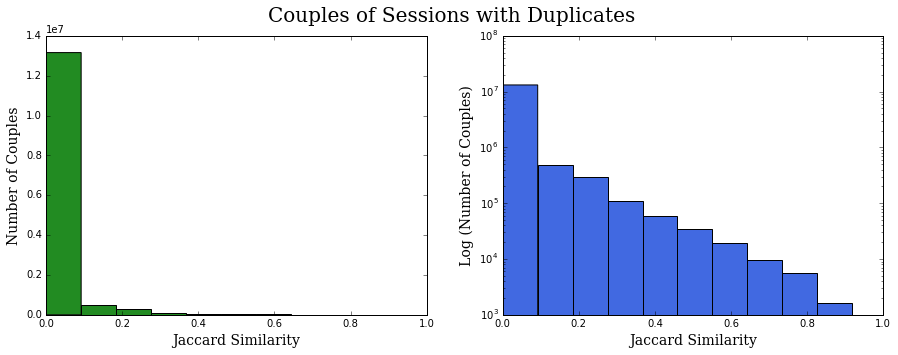

In [11]:
font_title = {'family': 'serif',
                   'weight': 'normal',
                   'verticalalignment': 'bottom',
                   'size': 20}

font_labels = {'family': 'serif',
                   'weight': 'normal',
                   'size': 14}   

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

print pd.Series(sessSimList).describe()

plt.figure(1, figsize = (15,5))
plt.suptitle("Couples of Sessions with Duplicates", fontdict = font_title , fontsize = 20)
plt.subplot(121)
plt.hist(sessSimList, bins = 10, log=False, color='forestgreen')
plt.xlabel('Jaccard Similarity', fontdict = font_labels)
plt.ylabel('Number of Couples', fontdict = font_labels)

plt.subplot(122)
plt.hist(sessSimList, bins = 10, log=True, color='royalblue')
plt.xlabel('Jaccard Similarity', fontdict = font_labels)
plt.ylabel('Log (Number of Couples)', fontdict = font_labels)


# Consider only couple from same User

In [12]:
def keep_play(x):
    objects = x['linkedinfo']['objects']
    x['linkedinfo']['objects'] = []
    
    for i in objects:
        if i['action'] == 'play':
            x['linkedinfo']['objects'].append(i['id'])          
    return (int(x['id']), x['linkedinfo']['objects'], x['linkedinfo']['subjects'][0]['id'])

def extract_ids(x):
    objects = x[1]
    result = []
    for i in objects:
        result.append( (i, x) )
    return result

train = trainRDD.map(keep_play)
trainFlat = train.flatMap(extract_ids)
trainJoin = trainFlat.join(songToClusterRDD)

In [13]:
clusterSession = trainJoin.map(lambda x: (x[1][1], (x[0], x[1][0][0] , x[1][0][1], x[1][0][2])))

clusterSessJoin = clusterSession.join(clusterSession)

def filter_sessions(x):
    item_1 = x[1][0]
    item_2 = x[1][1]
    
    if item_1[0] == item_2[0]:
        return False
    if item_1[1] == item_2[1]:
        return False
    if item_1[3] != item_2[3]:
        return False
    if item_1[0] in item_2[2] or item_2[0] in item_1[2]:
        return False
    return True
    
clusterSessFiltered = clusterSessJoin.filter(filter_sessions)
coupleSessions = clusterSessFiltered.map(lambda x: (x[1][0], x[1][1]))
coupleSessions.count()

151064

In [14]:
def compute_sim_sessions(x):
    sess1 = set(x[0][2])
    sess2 = set(x[1][2])
    
    jaccard = len(sess1 & sess2) / float(len(sess1 | sess2))
    
    return jaccard
    
sessUserSim = coupleSessions.map(compute_sim_sessions).collect()

count    151064.000000
mean          0.169571
std           0.099859
min           0.000000
25%           0.095238
50%           0.193548
75%           0.250000
max           0.903226
dtype: float64


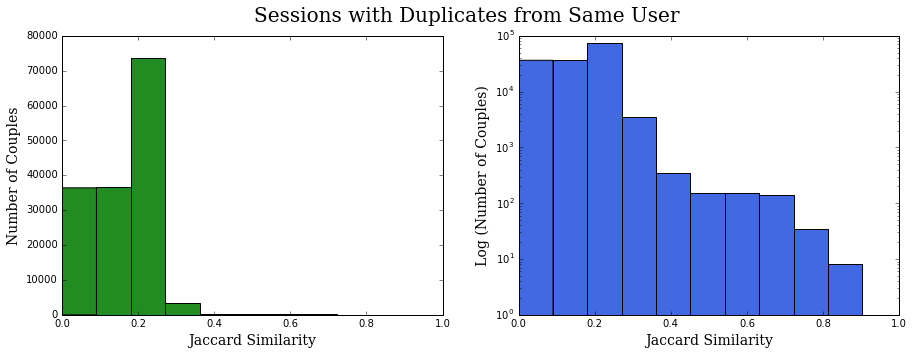

In [15]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

print pd.Series(sessUserSim).describe()


plt.figure(1, figsize = (15,5))
plt.suptitle("Sessions with Duplicates from Same User", fontdict = font_title , fontsize = 20)
plt.subplot(121)
plt.hist(sessUserSim, bins = 10, log=False, color='forestgreen')
plt.xlabel('Jaccard Similarity', fontdict = font_labels)
plt.ylabel('Number of Couples', fontdict = font_labels)

plt.subplot(122)
plt.hist(sessUserSim, bins = 10, log=True, color='royalblue')
plt.xlabel('Jaccard Similarity', fontdict = font_labels)
plt.ylabel('Log (Number of Couples)', fontdict = font_labels)

# What about random sessions?

In [16]:
trainSample = train.filter(lambda x: len(x[1]) > 1).takeSample(False, 5000, 42)

In [17]:
def compute_sim_sessions(x, y):
    sess1 = set(x)
    sess2 = set(y)
    
    jaccard = len(sess1 & sess2) / float(len(sess1 | sess2))    
    return jaccard

randomSimSess = []
for i, t in enumerate(trainSample):
    for j, v in enumerate(trainSample[:i]):
        jaccard = compute_sim_sessions(t[1], v[1])
        randomSimSess.append(jaccard)
   

count    12497500.000000
mean            0.000094
std             0.003424
min             0.000000
25%             0.000000
50%             0.000000
75%             0.000000
max             1.000000
dtype: float64


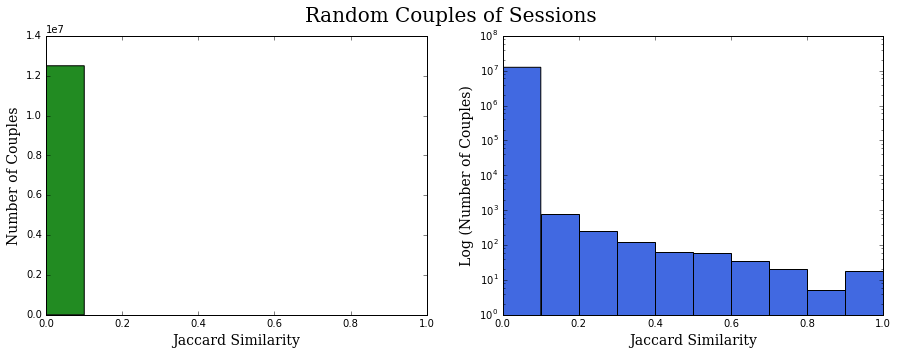

In [18]:

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

print pd.Series(randomSimSess).describe()

plt.figure(1, figsize = (15,5))
plt.suptitle("Random Couples of Sessions", fontdict = font_title , fontsize = 20)
plt.subplot(121)
plt.hist(randomSimSess, bins = 10, log=False, color='forestgreen')
plt.xlabel('Jaccard Similarity', fontdict = font_labels)
plt.ylabel('Number of Couples', fontdict = font_labels)

plt.subplot(122)
plt.hist(randomSimSess, bins = 10, log=True, color='royalblue')
plt.xlabel('Jaccard Similarity', fontdict = font_labels)
plt.ylabel('Log (Number of Couples)', fontdict = font_labels)

In [24]:
float(len([i for i in randomSimSess if i > .021535])) / float(len(randomSimSess)) * 100

0.13749949989998

# Sessions from Random Users

In [20]:
trainUser = train.map(lambda x: (x[2], x[1])).groupByKey().filter(lambda x: len(list(x[1])) > 5)
trainUserSample = sc.parallelize(trainUser.takeSample(False, 1000, 42)).mapValues(list)

In [21]:
def put_out_sim(x):
    result = []
    sessions = [i for i in x[1] if len(i) > 1]
    for i, t in enumerate(sessions):
        for j, k in enumerate(sessions[:i]):
            jaccard = compute_sim_sessions(t, k)
            result.append(jaccard)
    return result

randomUserSim = trainUserSample.flatMap(put_out_sim).collect()
print len(randomUserSim)
max(randomUserSim)

758152


1.0

count    758152.000000
mean          0.012297
std           0.072766
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
dtype: float64


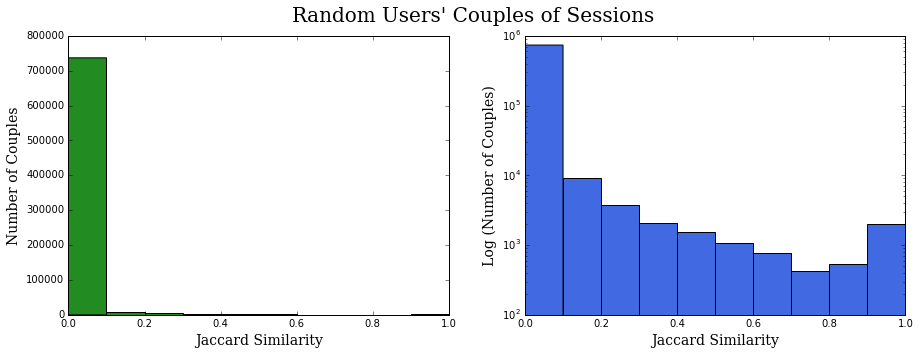

In [22]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

print pd.Series(randomUserSim).describe()

plt.figure(1, figsize = (15,5))
plt.suptitle("Random Users' Couples of Sessions", fontdict = font_title , fontsize = 20)
plt.subplot(121)
plt.hist(randomUserSim, bins = 10, log=False, color='forestgreen')
plt.xlabel('Jaccard Similarity', fontdict = font_labels)
plt.ylabel('Number of Couples', fontdict = font_labels)

plt.subplot(122)
plt.hist(randomUserSim, bins = 10, log=True, color='royalblue')
plt.xlabel('Jaccard Similarity', fontdict = font_labels)
plt.ylabel('Log (Number of Couples)', fontdict = font_labels)

In [23]:
float(len([i for i in randomUserSim if i > .250000])) / float(len(randomUserSim)) * 100

1.262147959775876

In [26]:
train.count()

487637